In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

import torch.optim as optim


# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *

In [8]:
######################## Parameters ######################

# dataset params :
L = 128  # length of input images
data_modality = 'SEG'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs


# training params
BATCH_SIZE = 16
lr = 5e-4
epochs = 100
model_name = 'saved_models/seg_model_300.pth'


# model hyper-params :
K =  512 # num_embeddings
D =  64  # embedding_dim 
downsampling_factor = 8

use_residual = False # swicth to True if wants to use RQ-VAE
num_quantizers = 2
shared_codebook = False

beta = .25
decay = .8

In [3]:
#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)



In [4]:

# instanciate model :

VQ_VAE =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VQ_VAE.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


In [9]:

model.train()

train_loss_values    = []
commit_loss_values   = []
val_loss_values      = []


best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss  = []
    commit_loss = []

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commitement_Loss = model(inputs)
            
            # Loss and backward
            all_loss = model.loss_function(output, inputs, indices, commitement_Loss)
            loss = all_loss['loss']  # Use the loss function defined in the model
            recons_loss = all_loss['Reconstruction_Loss']
            commitement_Loss = all_loss['commitement_Loss']

            loss.backward()
            optimizer.step()
                        
            # Track running loss
            train_loss.append( recons_loss.item() )
            commit_loss.append( commitement_Loss.item() )

            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    train_loss_values.append( np.mean(train_loss))
    commit_loss_values.append( np.mean(commit_loss))

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, commit_loss_values)
        best_val_loss = val_loss

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader_MRI)))


print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:05<00:00, 21.08batch/s, loss=0.0146]


Training complete.


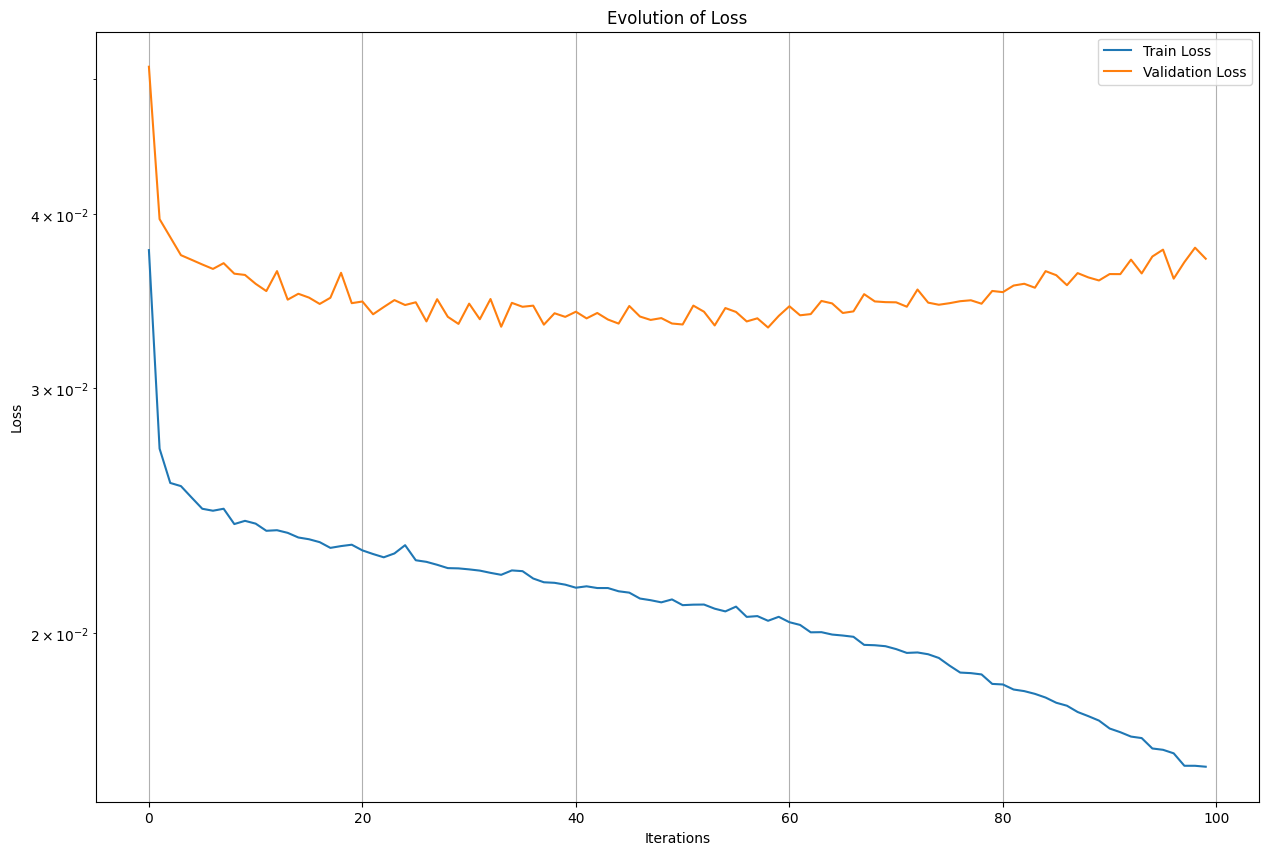

In [10]:
plot_train_val_loss(train_loss_values, val_loss_values)

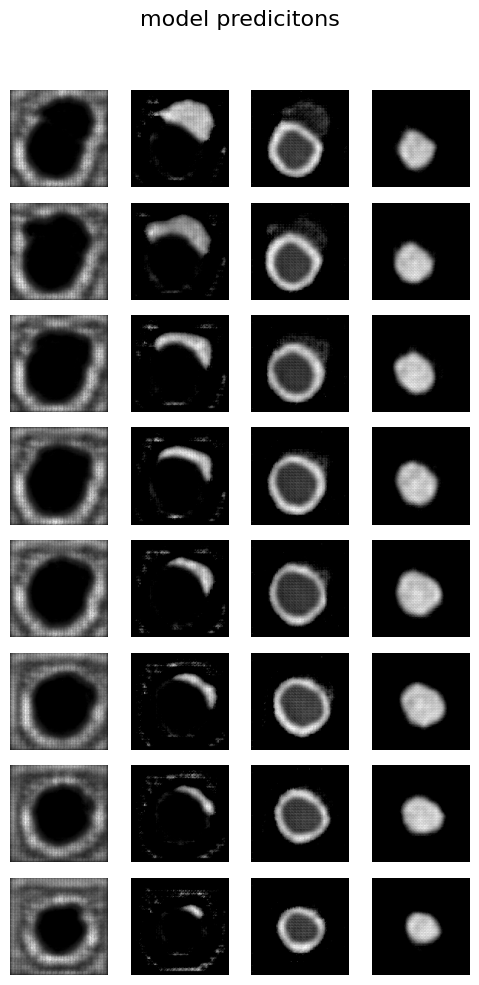

In [14]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

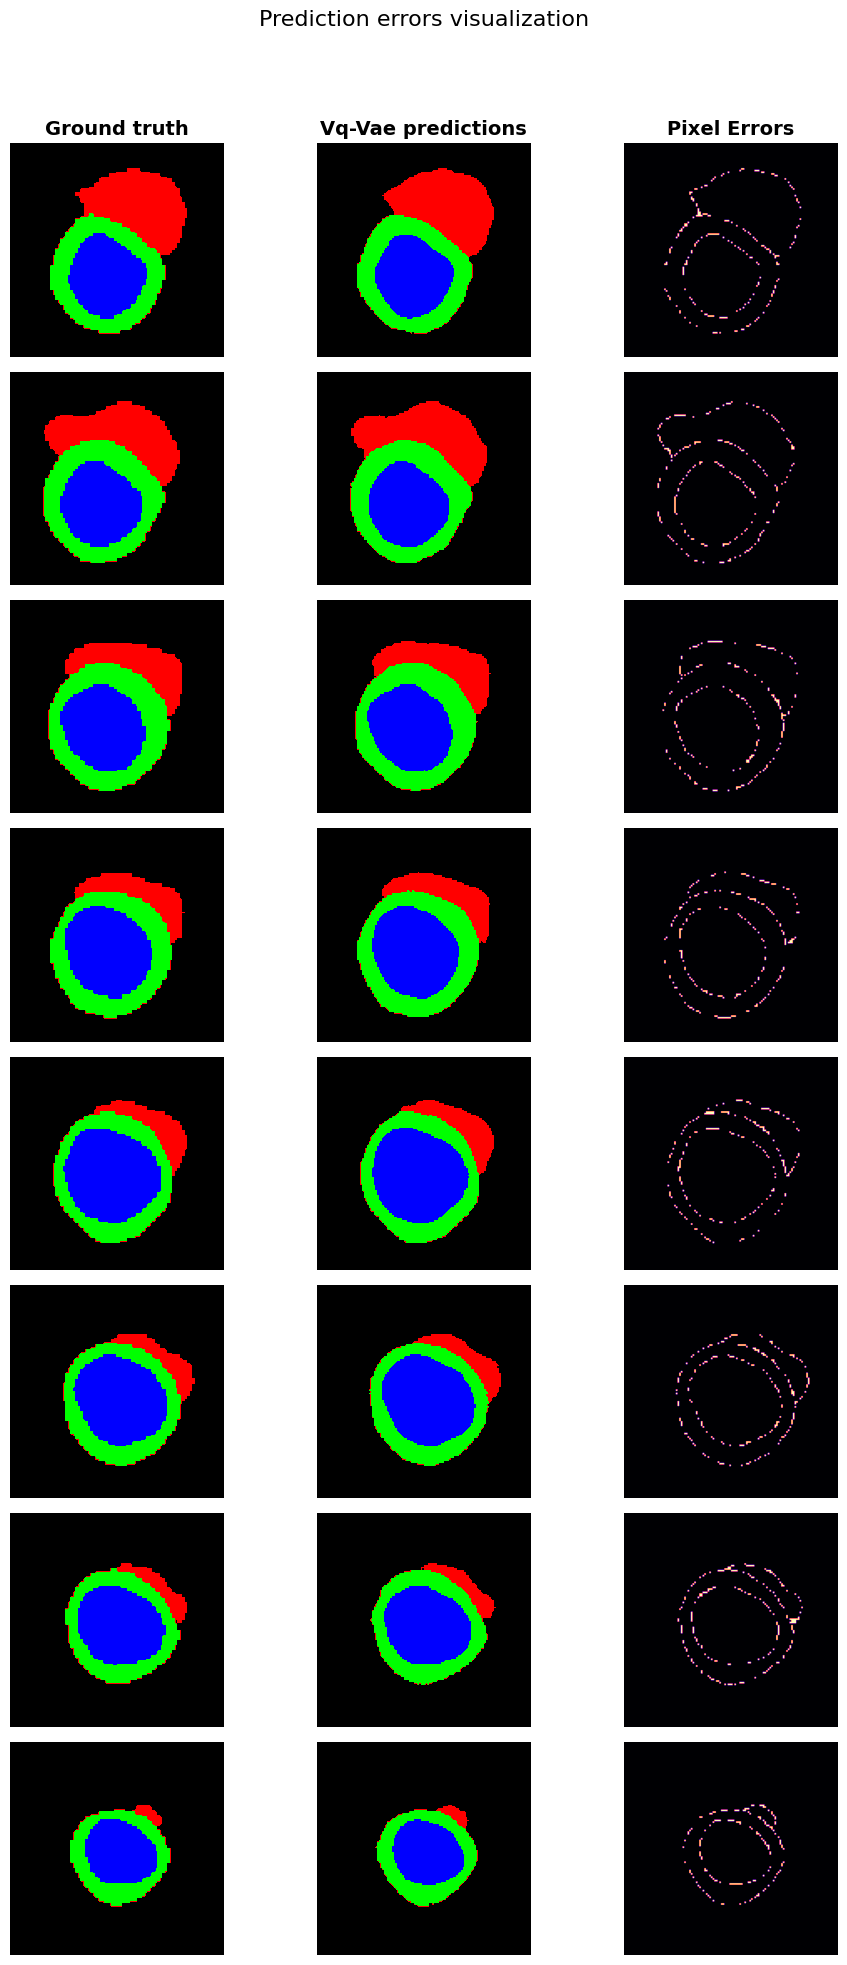

In [13]:

batch_hat = reconstruct_logits(vis_batch, model)
probs = F.softmax(batch_hat, dim=1) 

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_errors(true_seg, pred_seg, 'Prediction errors visualization')

In [16]:
print(score_model(model, TestLoader, device))

None
